# Convolutional Neural Networks - MNIST dataset

In the notebooks [Multi-Layer Perceptron - MNIST dataset](https://github.com/bljaime/MachineLearning-Portfolio/blob/master/P8_MultiLayerPerceptron_MNIST.ipynb) and [Data Augmentation. Multi-Layer Perceptron - MNIST dataset](https://github.com/bljaime/MachineLearning-Portfolio/blob/master/P9_DataAugmentation_MLP_MNIST.ipynb) we have been able to verify that neural networks outperform conventional classification algorithms in the classification of handmade numbers of the **MNIST** dataset. However, the **Multi-Layer Perceptron** itself presents several problems or limitations in some domains:

- It **disregards spatial information**, as it takes flattened vectors as inputs.
- It **does not take advantage of the modularity** of the problem, since, for example, trained to classify a 2, it would not be able to classify a 237.
- It is **not** very **robust** in the classification of **distorted images**, so to solve it a new training with these images is necessary.
- The **number of parameters increase dramatically**, considering that there is a high number of inputs, and using many hidden layers the number of synaptic weights of the net increases.

Then, the **Convolutional Neural Networks** emerged, which are robust to these situations mentioned where the Multi-Layer Perceptron was not, due to the application of filters.

So, let's go back to using the functions used in the *Data Augmentation* notebook to distort the images, but now let's classify them using **Convolutional Neural Networks**:

In [0]:
import numpy as np
import scipy as sc
import sklearn as sk
import pandas  as pd
import matplotlib.pyplot as plt

from tensorflow.keras.utils      import to_categorical

# We load the dataset from the file with pandas
mnist = pd.read_csv("./sample_data/mnist_train_small.csv", header=None).as_matrix()  # Save as numpy matrix

# X: sample attributes(20000x784), Y: sample labels (20000x1)
X, Y = mnist[:, 1:], mnist[:, 0:1]

Xt = X / 255  # Scale the data matrix (20000x744)
Yt = to_categorical(Y, 10)  # One-hot encoding: [1,0,0,...,0], [0,1,0,...,0], ..., [0,0,...,0,1]

def translation(X):  # Image set translation
  
  resul = np.zeros(X.shape)  # numpy array of 0s that serves as template
  
  for i, elem in enumerate(X):  # for each sample
    
    img = elem.reshape(28, 28)  # Make array of pixels look like a matrix
    xmov = np.random.randint(14) - 7  # Random translation coef. in x
    ymov = np.random.randint(14) - 7  # Random translation coef. in y
    resul[i] = sc.ndimage.shift(img, (xmov, ymov)).flatten()  # Apply the translation and flatten into a (784, 1)
    
  return resul


def rotation(X):  # Image set rotation
  
  resul = np.zeros(X.shape)
  
  for i, elem in enumerate(X):
    
    img = elem.reshape(28, 28)
    rot_ang = np.random.randint(180) - 90  # Random rotation coef.
    resul[i] = sc.ndimage.rotate(img, rot_ang, reshape=False).flatten()  # Apply the rotation angle and flatten into a (784, 1)
    
  return resul


def noise(X, p):  # Image set noising, with p: percentage of noise
  
  resul = np.zeros(X.shape)
  
  for i, elem in enumerate(X):
    
    img = elem.reshape(28, 28)
    noise = np.random.uniform(low=-p, high=p, size=(28, 28))  # Create noise mask 28x28 matrix with values in [-p, p)
    resul[i] = np.clip(img + noise, 0.0, 1.0).flatten()  # Sum the noise and, due to data is scaled, clipping between 0 and 1 is needed
    
  return resul

  # Create 4 new and different test sets, one for each distortion applied
transX = translation(Xt)
rotX = rotation(Xt)
noi25X = noise(Xt, 0.25)
noi50X = noise(Xt, 0.5)

# Assemble the original numbers and all the distorted sets
augmX = np.vstack([Xt, 
                    transX, 
                    rotX, 
                    noi25X, 
                    noi50X])

# Replicate label vector 5 times, el vector Y por 5 veces.
augmY = np.tile(Yt, (5,1))

# We shuffle to avoid data pools with the same label
data_xy = np.hstack((augmX, augmY))
np.random.shuffle(data_xy)
augmX = data_xy[:,:784]
augmY = data_xy[:,784:]

Let's visualize 3 images of our **augmented MNIST** dataset:

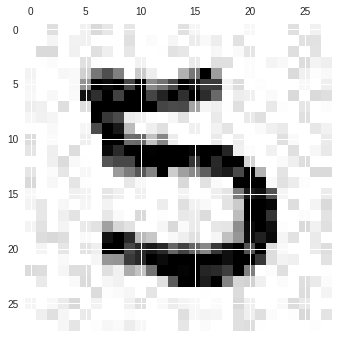

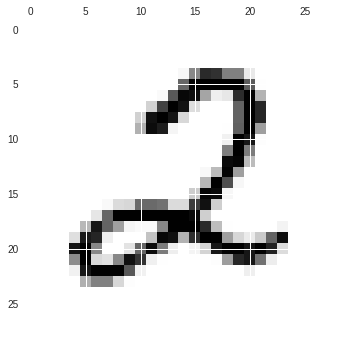

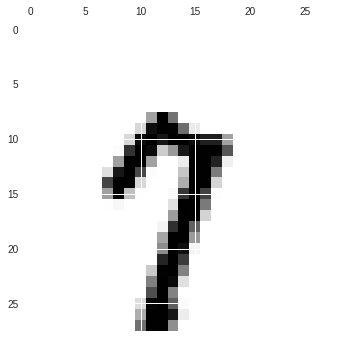

In [2]:
for i in range(3):
  plt.matshow(augmX[i,:].reshape(28, 28))
  plt.show()

Now, we will design a **Convolutional Neural Network** with **Keras** and we will train and evaluate it with the **augmented MNIST** dataset:

In [3]:
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten, BatchNormalization, Dropout

X_train, X_test, Y_train, Y_test = train_test_split(augmX, augmY, test_size=0.3)  # Partitioning in training and test data

  # Convolutional Neural network
  
CNN = Sequential()

  # 1st convolutional layer, max-pooling layer and BatchNormalization to regularize the CNN
CNN.add(Conv2D(kernel_size=8, strides=1, filters=32, padding='same', activation='relu'))  # 64 filters of 8x8x1 each, non-strided
CNN.add(Conv2D(kernel_size=4, strides=1, filters=32, padding='same', activation='relu'))
CNN.add(MaxPooling2D(pool_size=2, strides=1))  # max pooling layer with 2x2 kernel
CNN.add(BatchNormalization())

  # 2nd convolutional layer, max-pooling layer and BatchNormalization
CNN.add(Conv2D(kernel_size=4, strides=1, filters=64, padding='same', activation='relu'))
CNN.add(MaxPooling2D(pool_size=2, strides=1))
CNN.add(BatchNormalization())

  # Flatten the output of the CNN and connecting with the fully-connected layers
CNN.add(Flatten())

  # 1st fully-connected layer
CNN.add(Dense(128, activation='relu'))
CNN.add(BatchNormalization())
CNN.add(Dropout(0.3))
  # Output layer, classify using softmax
CNN.add(Dense(10, activation='softmax'))

CNN.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])


  # It is necessary to pass to the network as a dimension the number of channels
CNN_hist = CNN.fit(X_train.reshape(X_train.shape[0], 28, 28, 1),  # 1 channel: B&W
          Y_train,
          batch_size=32,
          epochs=12,
          verbose=1,
          validation_data=(X_test.reshape(X_test.shape[0], 28, 28, 1), Y_test))  # 1 channel: B&W
CNN.summary()

Train on 70000 samples, validate on 30000 samples
Epoch 1/12
70000/70000 [==============================] - 51s 728us/step - loss: 0.2481 - acc: 0.9225 - val_loss: 0.1240 - val_acc: 0.9637
Epoch 2/12
70000/70000 [==============================] - 49s 697us/step - loss: 0.0893 - acc: 0.9729 - val_loss: 0.1216 - val_acc: 0.9661
Epoch 3/12
70000/70000 [==============================] - 49s 696us/step - loss: 0.0617 - acc: 0.9813 - val_loss: 0.1130 - val_acc: 0.9702
Epoch 4/12
70000/70000 [==============================] - 49s 697us/step - loss: 0.0450 - acc: 0.9863 - val_loss: 0.1262 - val_acc: 0.9720
Epoch 5/12
70000/70000 [==============================] - 49s 697us/step - loss: 0.0393 - acc: 0.9885 - val_loss: 0.1085 - val_acc: 0.9753
Epoch 6/12
70000/70000 [==============================] - 49s 697us/step - loss: 0.0333 - acc: 0.9904 - val_loss: 0.1571 - val_acc: 0.9721
Epoch 7/12
70000/70000 [==============================] - 49s 696us/step - loss: 0.0275 - acc: 0.9919 - val_loss: 0.

Using *CNN.summary()* we can see a representation of the model, which gathers all relevant information about the architecture of the model itself. As we can see, the **Convolutional Neural Networks** have a great classifying power, by using elements such as filters or max. pooling layers that helps identifying very significant concrete parts of an image. This model has achieved a *validation accuracy* of approximately **97.8 %**.

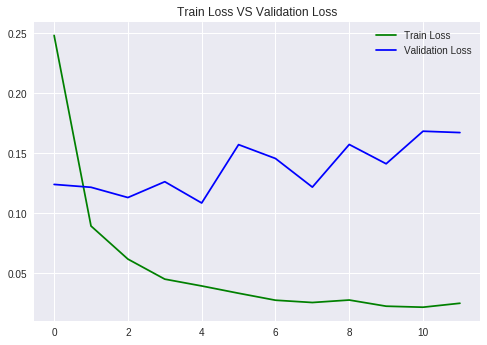

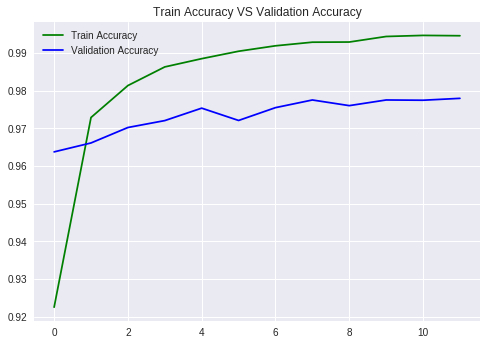

In [4]:

plt.title("Train Loss VS Validation Loss")
plt.plot(CNN_hist.history['loss'],     c='g')
plt.plot(CNN_hist.history['val_loss'], c='b')
plt.legend(['Train Loss', 'Validation Loss'])
plt.show()

plt.title("Train Accuracy VS Validation Accuracy")
plt.plot(CNN_hist.history['acc'],     c='g')
plt.plot(CNN_hist.history['val_acc'], c='b')
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.show()